In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import recall_score, make_scorer, accuracy_score, confusion_matrix, classification_report


In [60]:

# 1) Lectura de datos
df = pd.read_csv('data_resampled.csv')

# 2) Definición de X e y
TARGET_COL = 'Target'
TARGET_NAMES = ['Dropout', 'Enrolled', 'Graduate']

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]



#   División del dataset: 80% train / 20% test

In [61]:
# 3) División en train+val / test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# 4) División interna train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,        # 0.25 * 0.8 = 0.20 global → train:60%, val:20%, test:20%
    stratify=y_trainval,
    random_state=42
)

# Si X_test es un ndarray, lo reconstruimos como DataFrame
if not hasattr(X_test, "columns"):
    X_test = pd.DataFrame(X_test, columns=feature_names)

# Contar el desbalanceo de clases
print("Distribución de clases:")
print(y.value_counts(normalize=True))

Distribución de clases:
Target
2    0.373134
0    0.328358
1    0.298507
Name: proportion, dtype: float64


### Definición del scorer para recall de Dropout (clase 0)

In [31]:
# 5) Definición del scorer para recall de Dropout (clase 0)
def recall_dropout(y_true, y_pred):
    # average=None devuelve array [recall_clase0, recall_1, recall_2]
    return recall_score(y_true, y_pred, average=None)[0]

dropout_scorer = make_scorer(recall_dropout)

### Grid search preliminar (sin poda) para acotar hiperparámetros

In [32]:
# 6) Grid search preliminar (sin poda) para acotar hiperparámetros
param_grid = {
    'max_depth':      [3, 5, 7],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_samples_split':[10, 20, 30, 50],
}
best_cfg = {'score': -np.inf}

## BEST GINI TREE BASED ON RECALL DROPOUT


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# 1) Parameter grid combinando poda para árboles individuales
tree_grid = {
    'max_depth': [5, 7, 9],
    'min_samples_leaf': [1, 5, 10],
    'ccp_alpha': [0.0, 0.005, 0.01]
}

# 2) Montamos un RandomForest como ejemplo de ensemble
rf = RandomForestClassifier(random_state=42)
rf_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 7, 10],
    'min_samples_leaf': [1, 5, 10]
}

# 3) GridSearch para el árbol podado
gs_tree = GridSearchCV(
    DecisionTreeClassifier(criterion='gini', random_state=42),
    tree_grid,
    scoring=lambda est, X, y: recall_dropout(y, est.predict(X)),
    cv=5,
    n_jobs=-1
)
gs_tree.fit(X_train, y_train)
print("Mejor árbol podado:", gs_tree.best_params_, "->", gs_tree.best_score_)

# 4) GridSearch para RandomForest
gs_rf = GridSearchCV(
    rf,
    rf_grid,
    scoring=lambda est, X, y: recall_dropout(y, est.predict(X)),
    cv=5,
    n_jobs=-1
)
gs_rf.fit(X_train, y_train)
print("Mejor RandomForest:", gs_rf.best_params_, "->", gs_rf.best_score_)


Mejor árbol podado: {'ccp_alpha': 0.0, 'max_depth': 9, 'min_samples_leaf': 10} -> 0.7212121212121212
Mejor RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100} -> 0.793939393939394


In [59]:
# 1) Debug de formas
print("Forma de X_test antes de predecir:", X_test.shape)

# 2) Si es 1D, reshape a 2D
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)
    print("Forma de X_test tras reshape:", X_test.shape)

# 3) Predicción y métricas
y_test_pred = best_rf.predict(X_test)
print("Recall (dropout) en test:", recall_dropout(y_test, y_test_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Forma de X_test antes de predecir: (500,)
Forma de X_test tras reshape: (500, 1)


C:\Users\valuv\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but RandomForestClassifier is expecting 93 features as input.

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

# Usamos el mejor RF
best_rf = gs_rf.best_estimator_

# Predicción sobre test
y_test_pred = best_rf.predict(X_test)

# Matriz de confusión y métricas
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))
print("Recall (dropout) en test:", recall_dropout(y_test, y_test_pred))


C:\Users\valuv\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[0.         0.00200401 0.00400802 0.00601202 0.00801603 0.01002004
 0.01202405 0.01402806 0.01603206 0.01803607 0.02004008 0.02204409
 0.0240481  0.0260521  0.02805611 0.03006012 0.03206413 0.03406814
 0.03607215 0.03807615 0.04008016 0.04208417 0.04408818 0.04609219
 0.04809619 0.0501002  0.05210421 0.05410822 0.05611223 0.05811623
 0.06012024 0.06212425 0.06412826 0.06613226 0.06813627 0.07014028
 0.07214429 0.0741483  0.0761523  0.07815631 0.08016032 0.08216433
 0.08416834 0.08617234 0.08817635 0.09018036 0.09218437 0.09418838
 0.09619238 0.09819639 0.1002004  0.10220441 0.10420842 0.10621242
 0.10821643 0.11022044 0.11222445 0.11422846 0.11623246 0.11823647
 0.12024048 0.12224449 0.1242485  0.1262525  0.12825651 0.13026053
 0.13226452 0.13426854 0.13627255 0.13827655 0.14028056 0.14228457
 0.14428858 0.14629258 0.1482966  0.1503006  0.1523046  0.15430862
 0.15631263 0.15831663 0.16032064 0.16232465 0.16432866 0.16633266
 0.16833667 0.17034069 0.17234468 0.1743487  0.17635271 0.1783567
 0.18036072 0.18236473 0.18436874 0.18637274 0.18837675 0.19038077
 0.19238476 0.19438878 0.19639279 0.19839679 0.2004008  0.20240481
 0.20440882 0.20641282 0.20841683 0.21042085 0.21242484 0.21442886
 0.21643287 0.21843687 0.22044088 0.22244489 0.2244489  0.2264529
 0.22845691 0.23046093 0.23246492 0.23446894 0.23647295 0.23847695
 0.24048096 0.24248497 0.24448898 0.24649298 0.248497   0.250501
 0.252505   0.25450903 0.25651303 0.25851703 0.26052105 0.26252505
 0.26452905 0.26653308 0.26853707 0.27054107 0.2725451  0.2745491
 0.2765531  0.27855712 0.28056112 0.28256512 0.28456914 0.28657314
 0.28857717 0.29058117 0.29258516 0.2945892  0.2965932  0.2985972
 0.3006012  0.3026052  0.3046092  0.30661324 0.30861723 0.31062123
 0.31262526 0.31462926 0.31663325 0.31863728 0.32064128 0.32264528
 0.3246493  0.3266533  0.32865733 0.33066133 0.33266532 0.33466935
 0.33667335 0.33867735 0.34068137 0.34268537 0.34468937 0.3466934
 0.3486974  0.3507014  0.35270542 0.35470942 0.3567134  0.35871744
 0.36072144 0.36272544 0.36472946 0.36673346 0.3687375  0.3707415
 0.37274548 0.3747495  0.3767535  0.3787575  0.38076153 0.38276553
 0.38476953 0.38677356 0.38877755 0.39078155 0.39278558 0.39478958
 0.39679357 0.3987976  0.4008016  0.4028056  0.40480962 0.40681362
 0.40881765 0.41082165 0.41282564 0.41482967 0.41683367 0.41883767
 0.4208417  0.4228457  0.4248497  0.42685372 0.4288577  0.4308617
 0.43286574 0.43486974 0.43687373 0.43887776 0.44088176 0.4428858
 0.44488978 0.44689378 0.4488978  0.4509018  0.4529058  0.45490983
 0.45691383 0.45891783 0.46092185 0.46292585 0.46492985 0.46693388
 0.46893787 0.47094187 0.4729459  0.4749499  0.4769539  0.47895792
 0.48096192 0.48296595 0.48496994 0.48697394 0.48897797 0.49098197
 0.49298596 0.49499    0.496994   0.498998   0.501002   0.50300604
 0.50501    0.50701404 0.50901806 0.51102203 0.51302606 0.5150301
 0.51703405 0.5190381  0.5210421  0.5230461  0.5250501  0.52705413
 0.5290581  0.5310621  0.53306615 0.5350701  0.53707415 0.5390782
 0.54108214 0.5430862  0.5450902  0.54709417 0.5490982  0.5511022
 0.5531062  0.5551102  0.55711424 0.5591182  0.56112224 0.56312627
 0.56513023 0.56713426 0.5691383  0.57114226 0.5731463  0.5751503
 0.57715434 0.5791583  0.58116233 0.58316636 0.5851703  0.58717436
 0.5891784  0.59118235 0.5931864  0.5951904  0.5971944  0.5991984
 0.6012024  0.6032064  0.6052104  0.60721445 0.6092184  0.61122245
 0.6132265  0.61523044 0.61723447 0.6192385  0.62124246 0.6232465
 0.6252505  0.6272545  0.6292585  0.63126254 0.6332665  0.63527054
 0.63727456 0.63927853 0.64128256 0.6432866  0.64529055 0.6472946
 0.6492986  0.6513026  0.6533066  0.65531063 0.65731466 0.6593186
 0.66132265 0.6633267  0.66533065 0.6673347  0.6693387  0.6713427
 0.6733467  0.6753507  0.6773547  0.6793587  0.68136275 0.6833667
 0.68537074 0.6873748  0.68937874 0.69138277 0.6933868  0.69539076
 0.6973948  0.6993988  0.7014028  0.7034068  0.70541084 0.7074148
 0.70941883 0.71142286 0.7134268  0.71543086 0.7174349  0.71943885
 0.7214429  0.7234469  0.7254509  0.7274549  0.7294589  0.73146296
 0.7334669  0.73547095 0.737475   0.73947895 0.741483   0.743487
 0.74549097 0.747495   0.749499   0.751503   0.753507   0.75551105
 0.757515   0.75951904 0.76152307 0.76352704 0.76553106 0.7675351
 0.76953906 0.7715431  0.7735471  0.7755511  0.7775551  0.77955914
 0.7815631  0.78356713 0.78557116 0.7875751  0.78957915 0.7915832
 0.79358715 0.7955912  0.7975952  0.7995992  0.8016032  0.8036072
 0.8056112  0.8076152  0.80961925 0.8116233  0.81362724 0.8156313
 0.8176353  0.81963927 0.8216433  0.8236473  0.8256513  0.8276553
 0.82965934 0.8316633  0.83366734 0.83567137 0.83767533 0.83967936
 0.8416834  0.84368736 0.8456914  0.8476954  0.8496994  0.8517034
 0.85370743 0.8557114  0.8577154  0.85971946 0.8617234  0.86372745
 0.8657315  0.86773545 0.8697395  0.8717435  0.87374747 0.8757515
 0.8777555  0.8797595  0.8817635  0.88376755 0.8857716  0.88777554
 0.88977957 0.8917836  0.89378756 0.8957916  0.8977956  0.8997996
 0.9018036  0.90380764 0.9058116  0.90781564 0.90981966 0.91182363
 0.91382766 0.9158317  0.91783565 0.9198397  0.9218437  0.9238477
 0.9258517  0.92785573 0.9298597  0.9318637  0.93386775 0.9358717
 0.93787575 0.9398798  0.94188374 0.94388777 0.9458918  0.94789577
 0.9498998  0.9519038  0.9539078  0.9559118  0.95791584 0.9599198
 0.96192384 0.96392787 0.9659319  0.96793586 0.9699399  0.9719439
 0.9739479  0.9759519  0.97795594 0.9799599  0.98196393 0.98396796
 0.9859719  0.98797596 0.98998    0.99198395 0.993988   0.995992
 0.997996   1.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Métricas de evaluación del modelo


Accuracy del mejor modelo:
0.7380597014925373

Matriz de confusión del mejor modelo:

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.79      0.75      0.77       440
    Enrolled       0.63      0.65      0.64       400
    Graduate       0.78      0.80      0.79       500

    accuracy                           0.74      1340
   macro avg       0.73      0.73      0.73      1340
weighted avg       0.74      0.74      0.74      1340



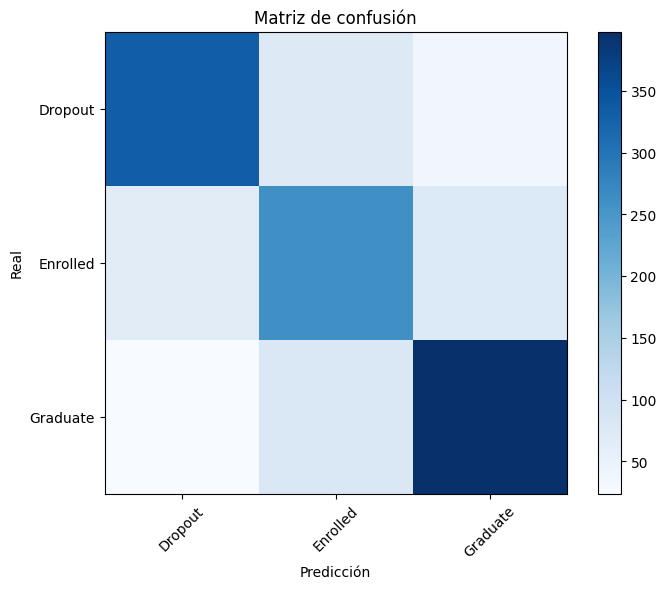

In [34]:
# accuracy
print("\nAccuracy del mejor modelo:")
clf = DecisionTreeClassifier(
    criterion='gini',
    min_samples_leaf=best_cfg['min_samples_leaf'],
    min_samples_split=best_cfg['min_samples_split'],
    max_depth=best_cfg['max_depth'],
    random_state=42
).fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
print(accuracy_score(y_val, y_val_pred))

print("\nMatriz de confusión del mejor modelo:")
cm = confusion_matrix(y_val, y_val_pred)
cm_df = pd.DataFrame(cm, index=TARGET_NAMES, columns=TARGET_NAMES)
cm_df.index.name = 'Real'
cm_df.columns.name = 'Predicción'
plt.figure(figsize=(8, 6))
plt.title('Matriz de confusión')

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_val, y_val_pred, target_names=TARGET_NAMES))
plt.imshow(cm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(TARGET_NAMES)), TARGET_NAMES, rotation=45)
plt.yticks(np.arange(len(TARGET_NAMES)), TARGET_NAMES)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()



### Visualización del árbol

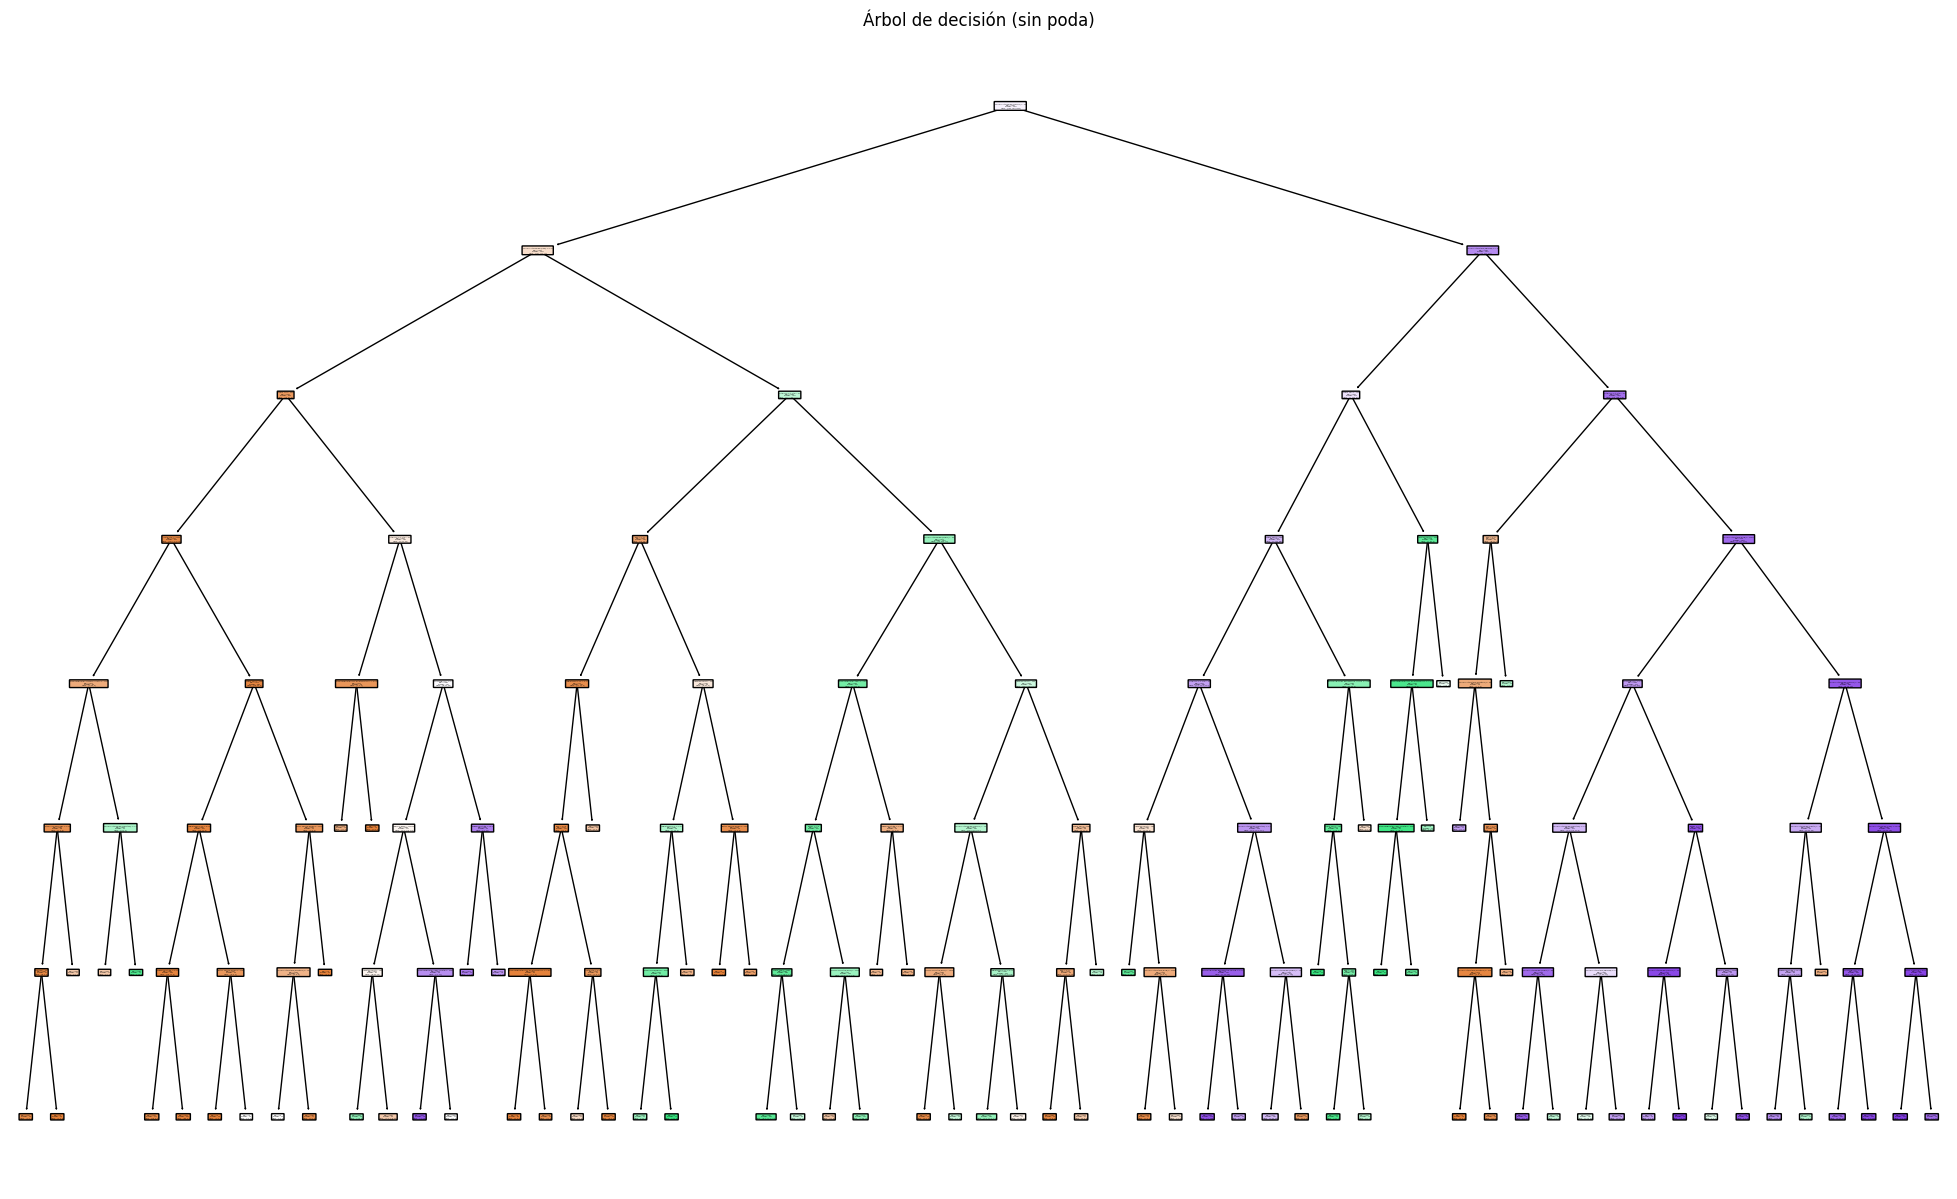

In [35]:
plt.figure(figsize=(25,15))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=TARGET_NAMES,
    filled=True,
    fontsize=1,
    rounded=True
)
plt.title('Árbol de decisión (sin poda)')
plt.savefig('arboles/arbol_gini_decision.svg', format='svg')
plt.show()

In [36]:
best_cfg

{'max_depth': 7,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'score': 0.7522727272727273}

###  Cost-Complexity Pruning: obtenemos alphas del árbol “completo”

In [37]:
clf_full = DecisionTreeClassifier(
    criterion='gini',
    max_depth=best_cfg['max_depth'],
    min_samples_leaf=best_cfg['min_samples_leaf'],
    min_samples_split=best_cfg['min_samples_split'],
    random_state=42
).fit(X_train, y_train)

path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]   # descartamos último alpha trivial

### CV para cada ccp_alpha, midiendo recall_dropout

In [38]:
alpha_scores = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        criterion='gini',
        ccp_alpha=alpha,
        min_samples_leaf=best_cfg['min_samples_leaf'],
        min_samples_split=best_cfg['min_samples_split'],
        max_depth=best_cfg['max_depth'],
        random_state=42
    )
    cv_scores = cross_val_score(
        clf, X_train, y_train,
        cv=5,
        scoring=dropout_scorer,
        error_score=np.nan
    )
    alpha_scores.append((alpha, np.nanmean(cv_scores)))

###  Selección del mejor alpha

In [39]:
best_alpha, best_alpha_score = max(alpha_scores, key=lambda x: x[1])
print(f"Mejor ccp_alpha: {best_alpha:.5f} con recall_dropout CV={best_alpha_score:.4f}")

Mejor ccp_alpha: 0.00081 con recall_dropout CV=0.7242


###  Reentrenamos el árbol podado final

In [44]:
final_clf = DecisionTreeClassifier(
    criterion='gini',
    ccp_alpha=best_alpha,
    min_samples_leaf=best_cfg['min_samples_leaf'],
    min_samples_split=best_cfg['min_samples_split'],
    max_depth=best_cfg['max_depth'],
    random_state=42
).fit(X_train, y_train)


In [45]:
final_clf.predict(X_test)

array([1, 2, 2, ..., 2, 2, 0], dtype=int64)

## Evaluación del modelo

### Validación


Accuracy del modelo podado:
0.7373134328358208

Matriz de confusión del modelo podado:


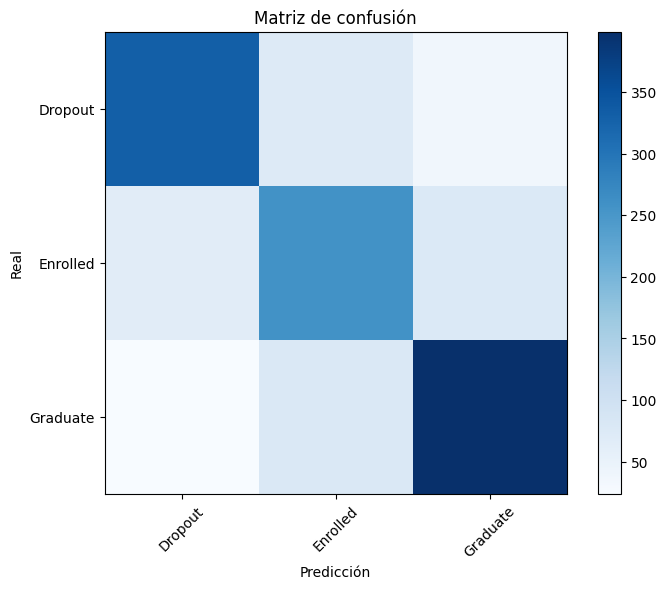


Reporte de clasificación del modelo podado:
              precision    recall  f1-score   support

     Dropout       0.79      0.75      0.77       440
    Enrolled       0.63      0.65      0.64       400
    Graduate       0.78      0.80      0.79       500

    accuracy                           0.74      1340
   macro avg       0.73      0.73      0.73      1340
weighted avg       0.74      0.74      0.74      1340



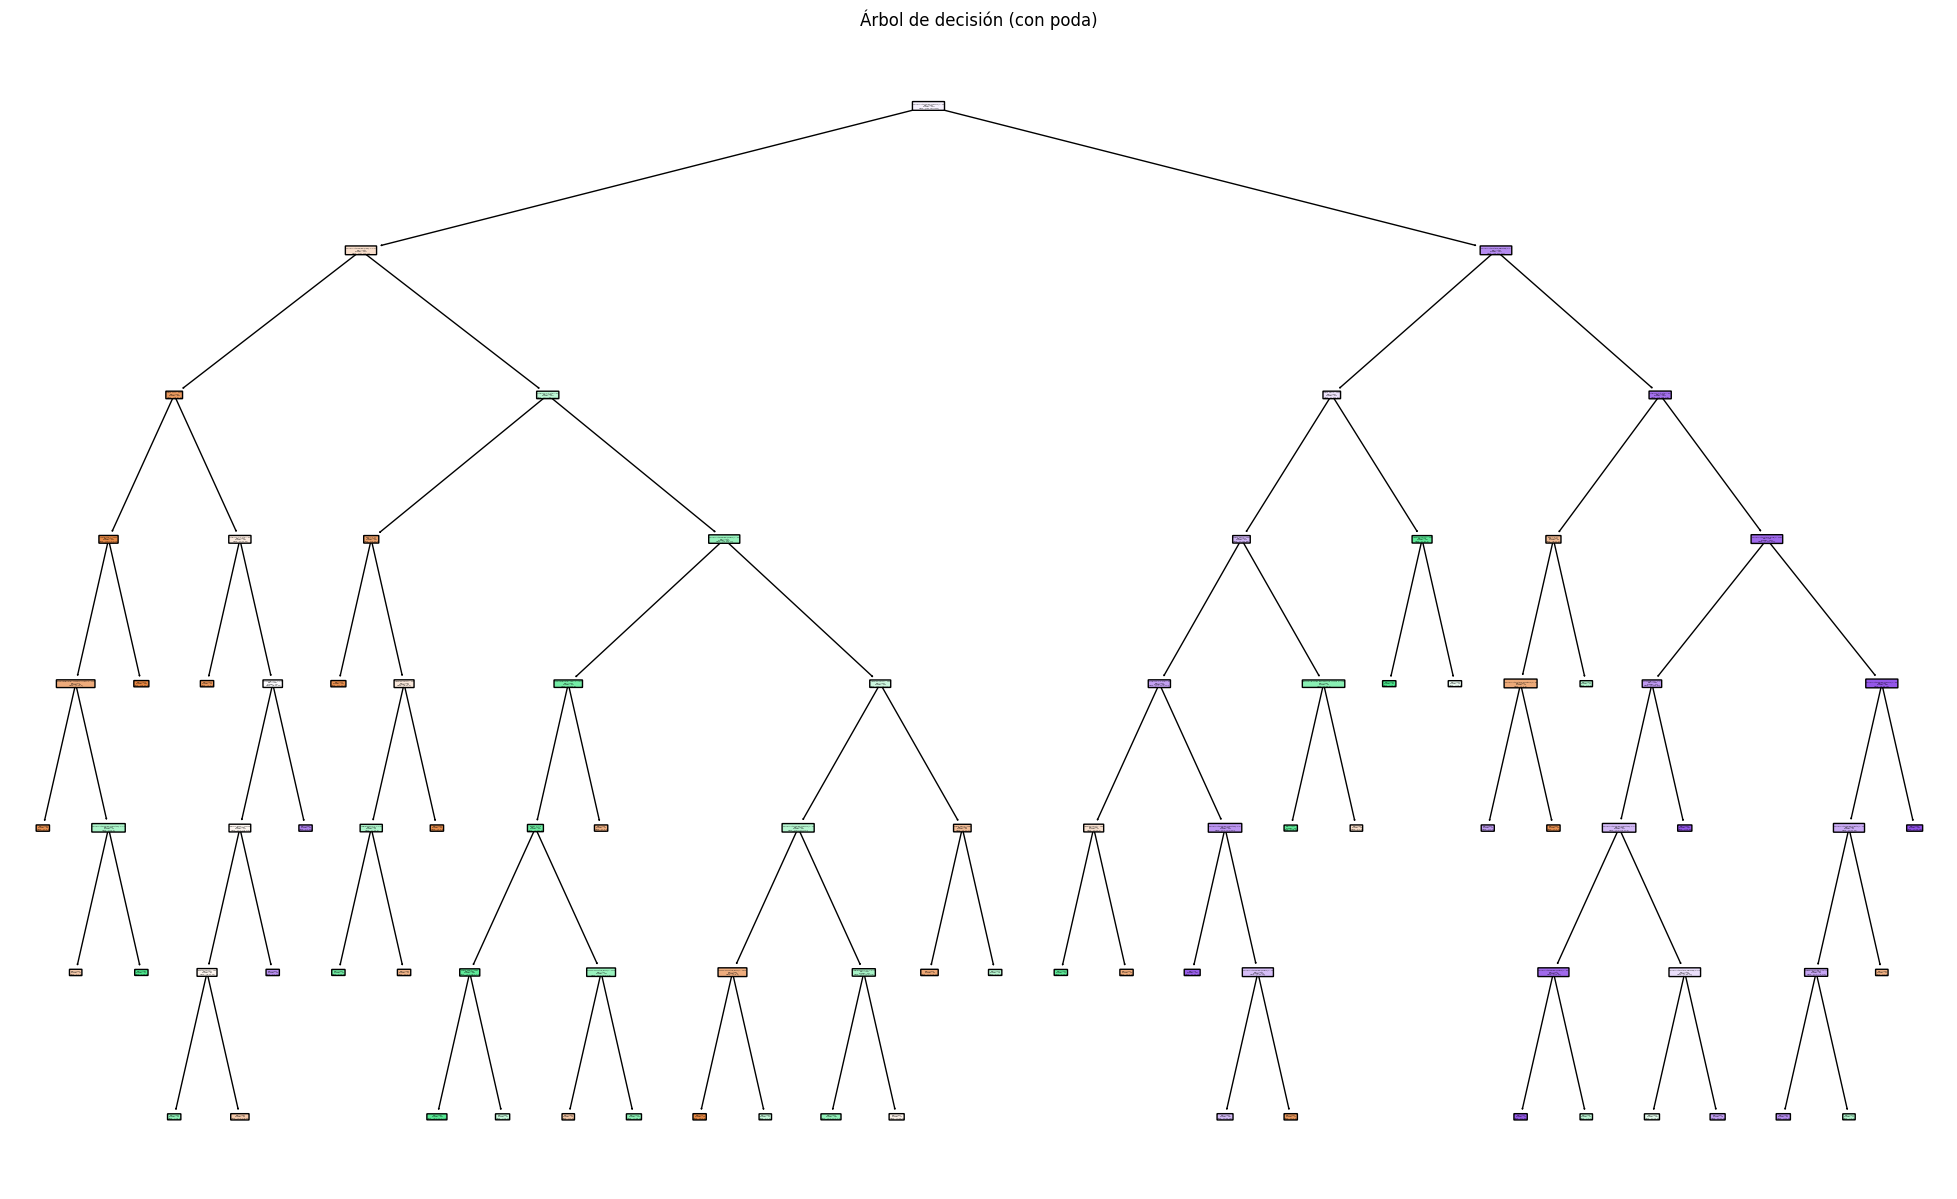

In [52]:
# 6. Evaluación en validación
# ----------------------------
y_val_pred = final_clf.predict(X_val)
print("\nAccuracy del modelo podado:")
print(accuracy_score(y_val, y_val_pred))
print("\nMatriz de confusión del modelo podado:")
cm = confusion_matrix(y_val, y_val_pred)
cm_df = pd.DataFrame(cm, index=TARGET_NAMES, columns=TARGET_NAMES)
cm_df.index.name = 'Real'
cm_df.columns.name = 'Predicción'
plt.figure(figsize=(8, 6))
plt.title('Matriz de confusión')
plt.imshow(cm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(TARGET_NAMES)), TARGET_NAMES, rotation=45)
plt.yticks(np.arange(len(TARGET_NAMES)), TARGET_NAMES)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()
print("\nReporte de clasificación del modelo podado:")
print(classification_report(y_val, y_val_pred, target_names=TARGET_NAMES))
plt.figure(figsize=(25,15))
plot_tree(
    final_clf,
    feature_names=X.columns,
    class_names=TARGET_NAMES,
    filled=True,
    fontsize=1,
    rounded=True
)
plt.title('Árbol de decisión (con poda)')
plt.savefig('arboles/arbol_gini_decision_poda.svg', format='svg')
plt.show()

In [46]:
y_test_pred = final_clf.predict(X_test)
print("\n🎯 Accuracy en test:", round(accuracy_score(y_test, y_test_pred),4))
print("\n↪ Recall por clase:")
recalls = recall_score(y_test, y_test_pred, average=None)
for idx, name in enumerate(TARGET_NAMES):
    print(f"   {name}: {recalls[idx]:.4f}")

print("\n📊 Matriz de confusión:\n", confusion_matrix(y_test, y_test_pred))
print("\n📄 Classification report:\n",
      classification_report(y_test, y_test_pred, target_names=TARGET_NAMES))


🎯 Accuracy en test: 0.7187

↪ Recall por clase:
   Dropout: 0.7068
   Enrolled: 0.6200
   Graduate: 0.8080

📊 Matriz de confusión:
 [[311  82  47]
 [ 65 248  87]
 [ 24  72 404]]

📄 Classification report:
               precision    recall  f1-score   support

     Dropout       0.78      0.71      0.74       440
    Enrolled       0.62      0.62      0.62       400
    Graduate       0.75      0.81      0.78       500

    accuracy                           0.72      1340
   macro avg       0.72      0.71      0.71      1340
weighted avg       0.72      0.72      0.72      1340



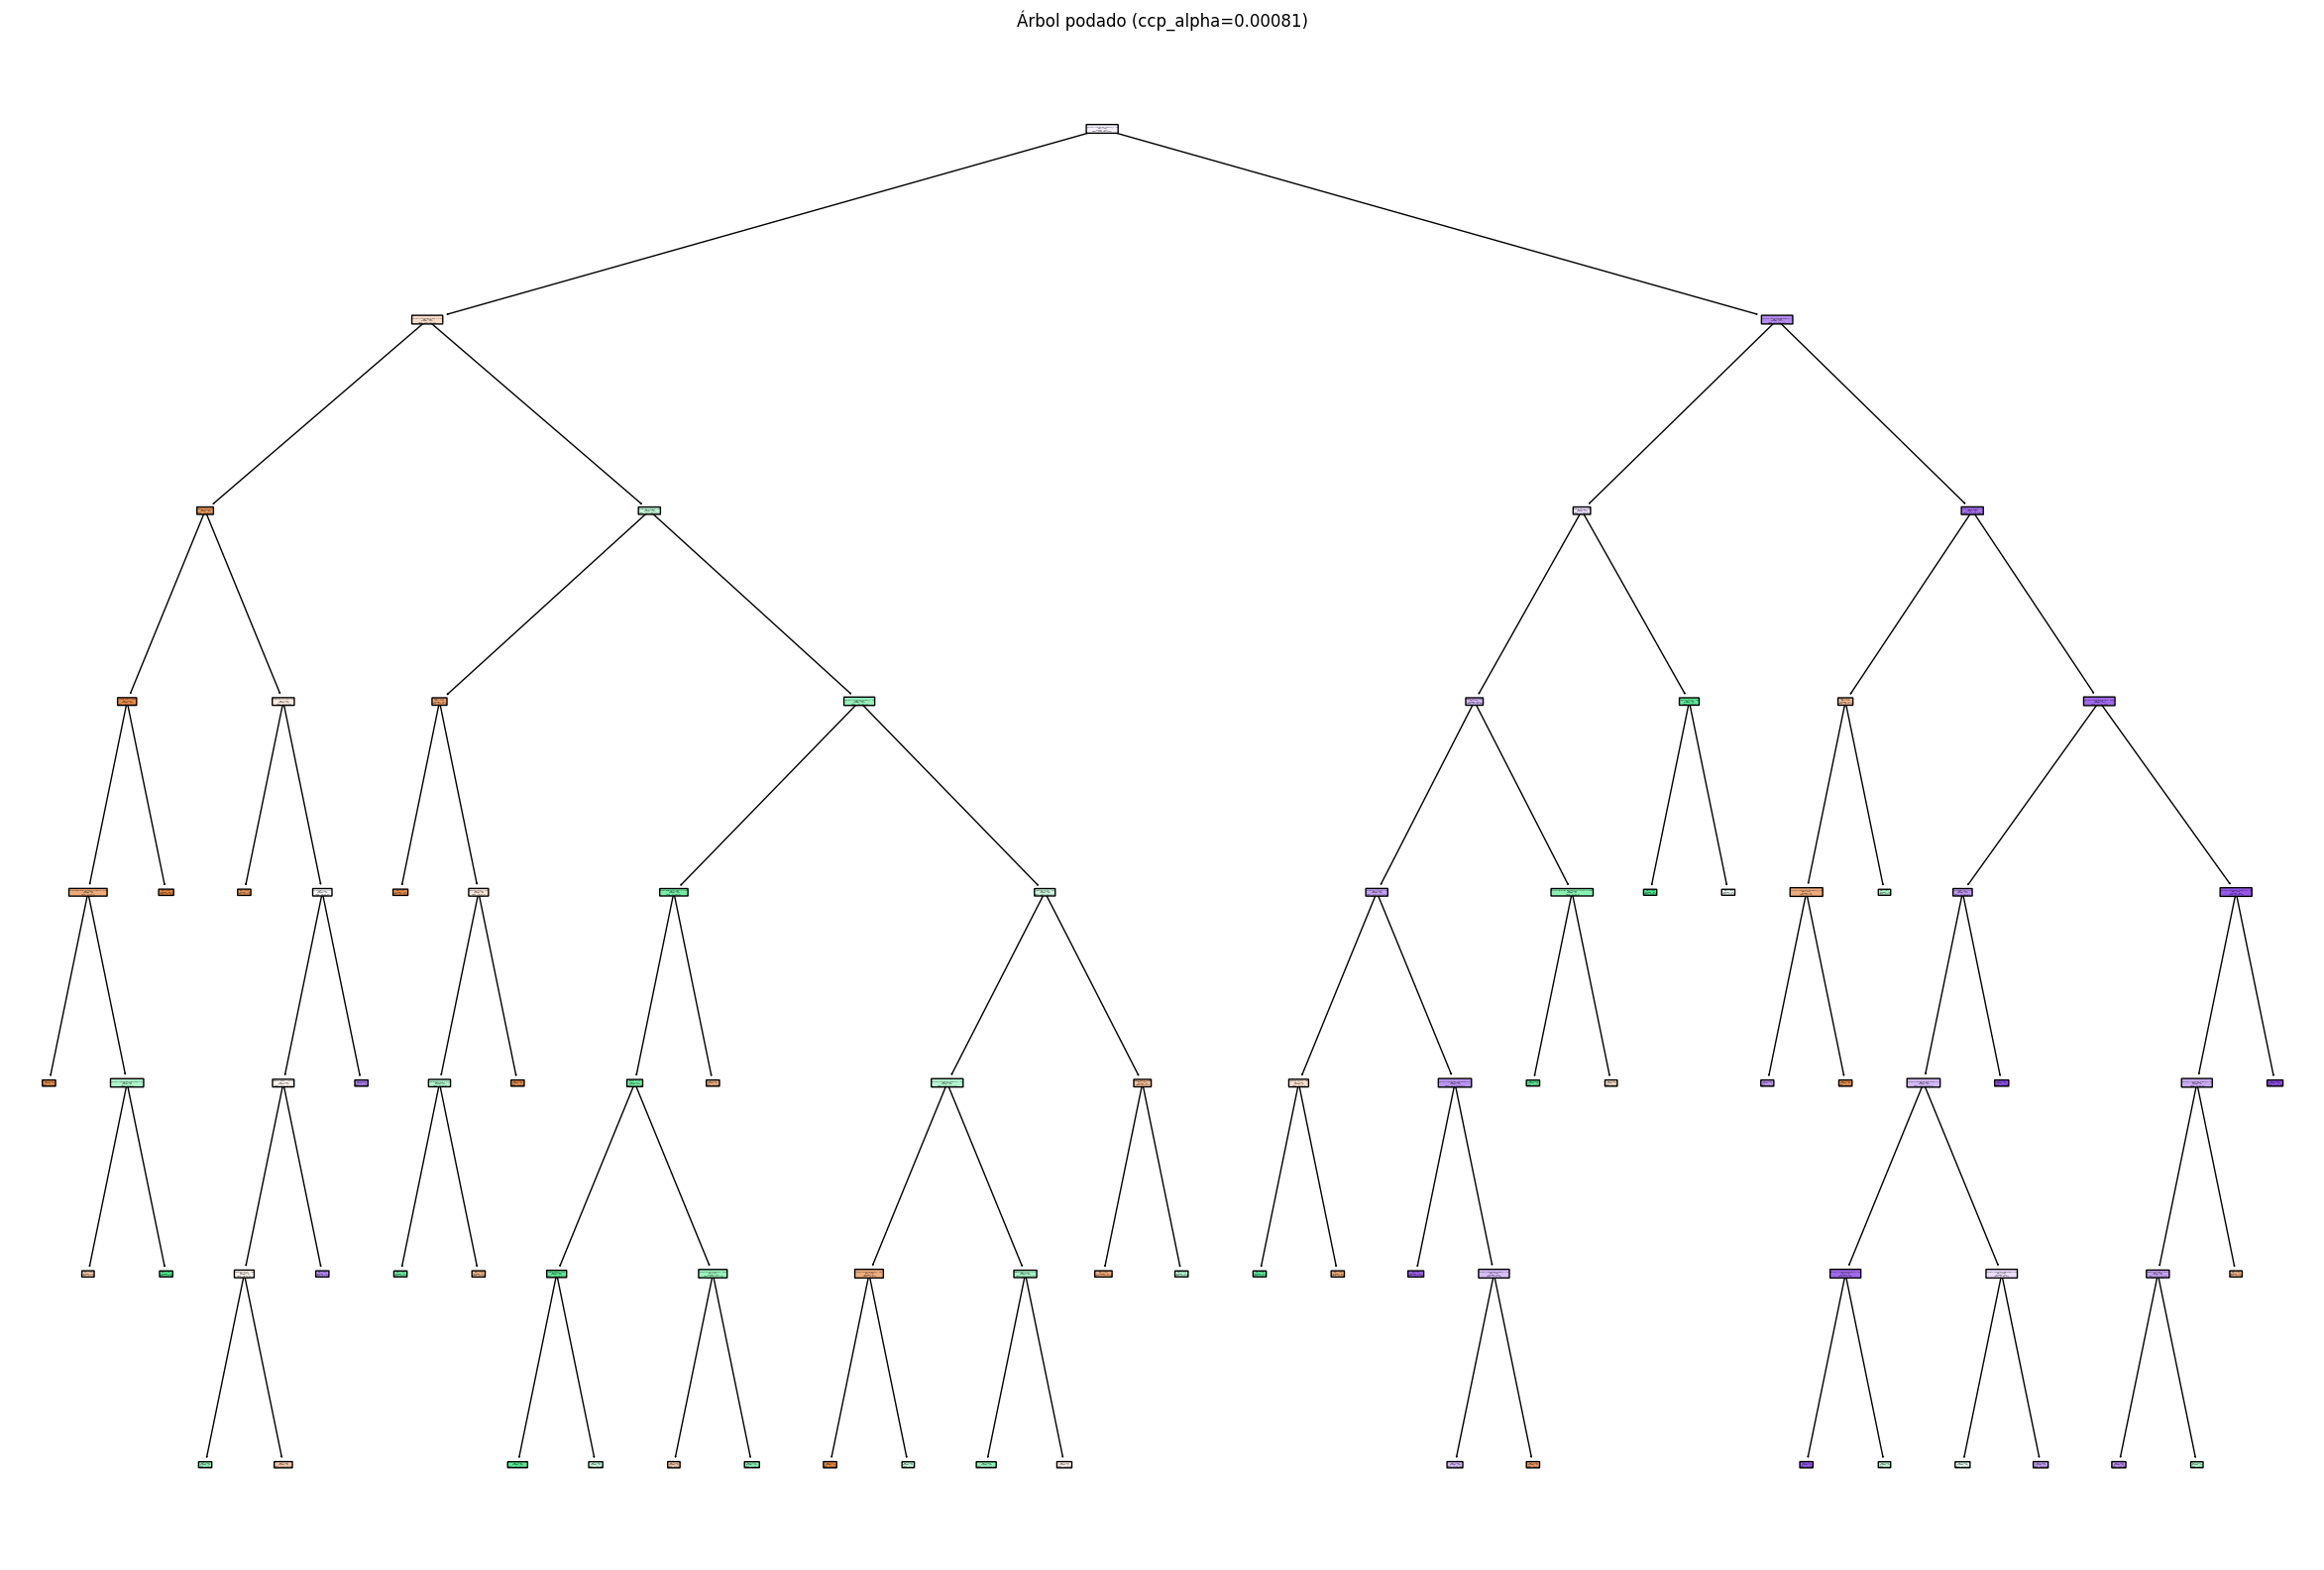

In [47]:
plt.figure(figsize=(30,20))
plot_tree(
    final_clf,
    feature_names=X.columns,
    class_names=TARGET_NAMES,
    filled=True,
    fontsize=1,
    rounded=True
)
plt.title(f"Árbol podado (ccp_alpha={best_alpha:.5f})")
plt.savefig('arboles/arbol_podado.svg', format='svg')
plt.show()

In [48]:
from sklearn.tree import _tree

def extract_dropout_rules_with_gini(clf, feature_names, class_names, target_class=0):
    """
    Recorre el árbol y devuelve una lista de tuplas:
      (condiciones, gini_impurity, support, proporción_clase_target)
    sólo para hojas que predicen target_class.
    """
    tree = clf.tree_
    # nombres de features o "leaf"
    feat_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "leaf"
        for i in tree.feature
    ]
    paths = []
    path_conditions = []

    def recurse(node):
        # Nodo interno
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feat_name[node]
            thresh = tree.threshold[node]
            # Hijo izquierdo
            path_conditions.append(f"{name} ≤ {thresh:.4f}")
            recurse(tree.children_left[node])
            path_conditions.pop()
            # Hijo derecho
            path_conditions.append(f"{name} > {thresh:.4f}")
            recurse(tree.children_right[node])
            path_conditions.pop()
        else:
            # Hoja: calculamos la clase predicha y métricas
            counts = tree.value[node][0]
            pred = counts.argmax()
            if pred == target_class:
                total = counts.sum()
                probs = counts / total
                # Coeficiente de Gini
                gini_impurity = 1.0 - (probs**2).sum()
                # Soporte y proporción de la clase Dropout
                support = int(total)
                pct_target = probs[target_class]
                rule = " AND ".join(path_conditions) or "(root)"
                paths.append((rule, gini_impurity, support, pct_target))
        return

    recurse(0)
    return paths

# Uso:
feature_names = list(X.columns)
class_names   = TARGET_NAMES  # ['Dropout','Enrolled','Graduate']

rules = extract_dropout_rules_with_gini(final_clf, feature_names, class_names, target_class=0)
print(f"Se han extraído {len(rules)} reglas que predicen Dropout:\n")
for idx, (rule, gini, sup, prop) in enumerate(rules, 1):
    print(f"{idx:2d}. Si {rule}")
    print(f"     → Gini impurity = {gini:.4f}, support = {sup}, P(Dropout) = {prop:.2%}\n")


Se han extraído 18 reglas que predicen Dropout:

 1. Si Curricular units 2nd sem (approved) ≤ 4.5000 AND Curricular units 2nd sem (grade) ≤ 0.6916 AND Course: 171 ≤ 0.5221 AND Inflation rate ≤ -0.3339 AND Father's qualification: Secondary education ≤ 0.1224
     → Gini impurity = 0.1855, support = 1, P(Dropout) = 89.66%

 2. Si Curricular units 2nd sem (approved) ≤ 4.5000 AND Curricular units 2nd sem (grade) ≤ 0.6916 AND Course: 171 ≤ 0.5221 AND Inflation rate ≤ -0.3339 AND Father's qualification: Secondary education > 0.1224 AND Curricular units 2nd sem (evaluations) ≤ 7.5000
     → Gini impurity = 0.4628, support = 1, P(Dropout) = 63.64%

 3. Si Curricular units 2nd sem (approved) ≤ 4.5000 AND Curricular units 2nd sem (grade) ≤ 0.6916 AND Course: 171 ≤ 0.5221 AND Inflation rate > -0.3339
     → Gini impurity = 0.0758, support = 1, P(Dropout) = 96.05%

 4. Si Curricular units 2nd sem (approved) ≤ 4.5000 AND Curricular units 2nd sem (grade) ≤ 0.6916 AND Course: 171 > 0.5221 AND Tuition

##  BEST ENTROPY TREE BASED ON RECALL DROPOUT

In [50]:
for cfg in ParameterGrid(param_grid):
    clf = DecisionTreeClassifier(
        criterion='entropy',
        **cfg,
        random_state=42
    ).fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    score = recall_dropout(y_val, y_val_pred)
    if score > best_cfg['score']:
        best_cfg = {**cfg, 'score': score}

print("Mejor configuración pre-poda:", best_cfg)

Mejor configuración pre-poda: {'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 10, 'score': 0.7522727272727273}


### Métricas de evaluación del modelo


Accuracy del mejor modelo:
0.7559701492537313

Matriz de confusión del mejor modelo:

Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

     Dropout       0.83      0.73      0.78       440
    Enrolled       0.66      0.65      0.66       400
    Graduate       0.77      0.86      0.81       500

    accuracy                           0.76      1340
   macro avg       0.75      0.75      0.75      1340
weighted avg       0.76      0.76      0.75      1340



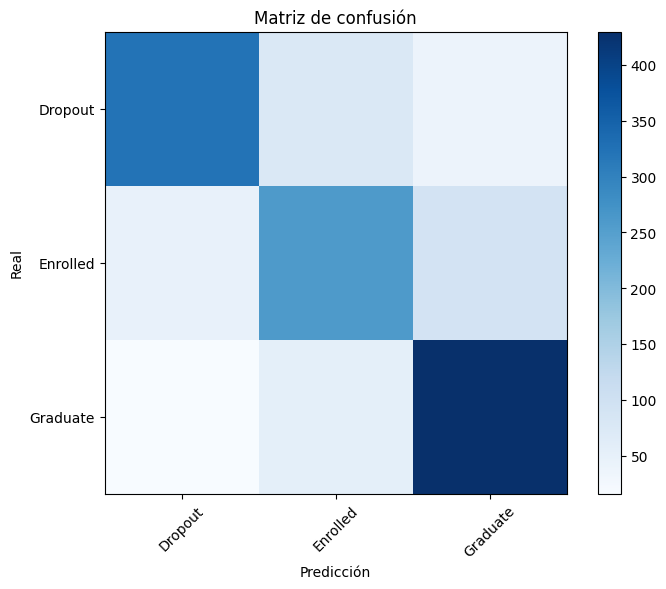

In [23]:
# accuracy
print("\nAccuracy del mejor modelo:")
clf = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=best_cfg['min_samples_leaf'],
    min_samples_split=best_cfg['min_samples_split'],
    max_depth=best_cfg['max_depth'],
    random_state=42
).fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
print(accuracy_score(y_val, y_val_pred))

print("\nMatriz de confusión del mejor modelo:")
cm = confusion_matrix(y_val, y_val_pred)
cm_df = pd.DataFrame(cm, index=TARGET_NAMES, columns=TARGET_NAMES)
cm_df.index.name = 'Real'
cm_df.columns.name = 'Predicción'
plt.figure(figsize=(8, 6))
plt.title('Matriz de confusión')

print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_val, y_val_pred, target_names=TARGET_NAMES))
plt.imshow(cm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(len(TARGET_NAMES)), TARGET_NAMES, rotation=45)
plt.yticks(np.arange(len(TARGET_NAMES)), TARGET_NAMES)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()



### Visualización del árbol

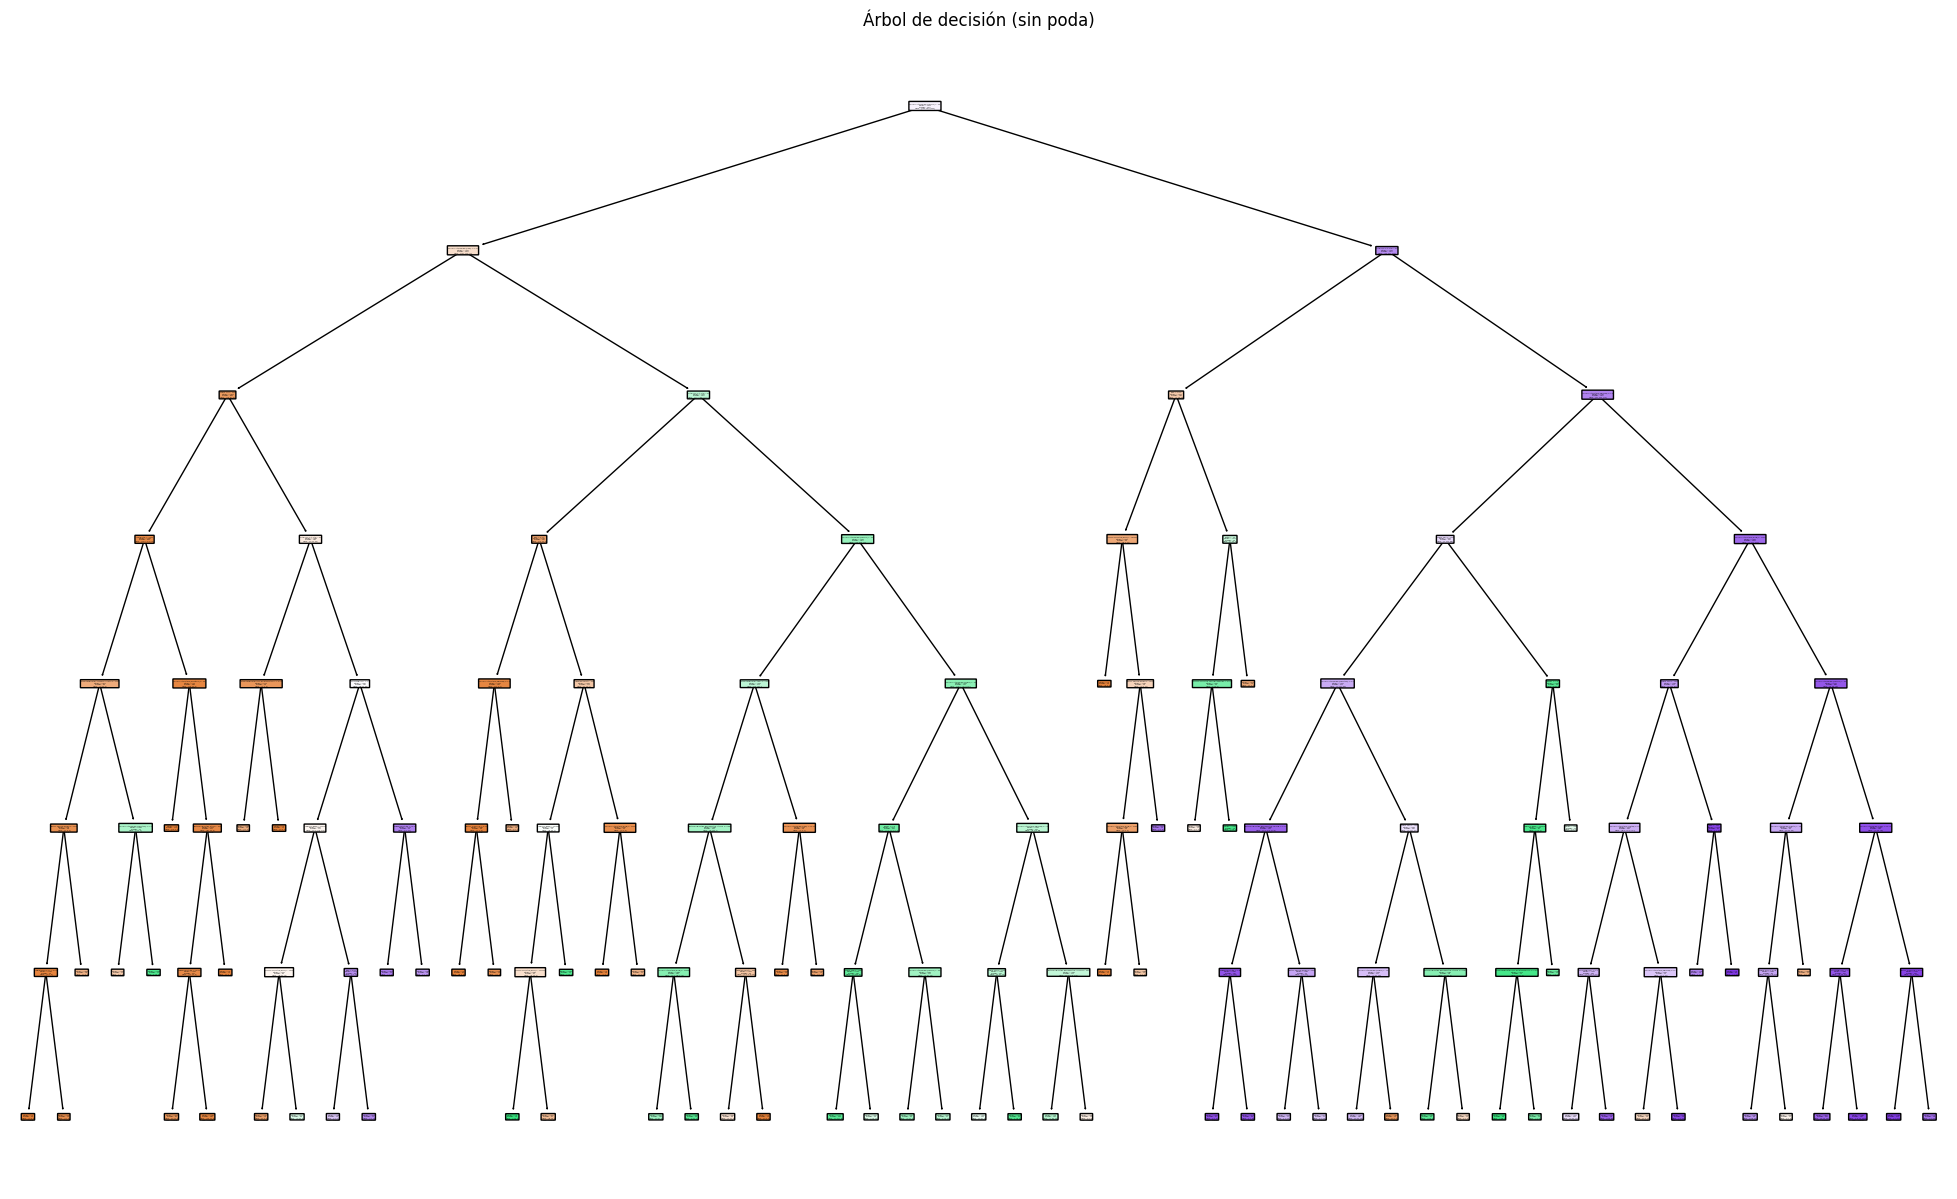

In [24]:
plt.figure(figsize=(25,15))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=TARGET_NAMES,
    filled=True,
    fontsize=1,
    rounded=True
)
plt.title('Árbol de decisión (sin poda)')
plt.savefig('arboles/arbol_entropy_decision.svg', format='svg')
plt.show()

###  Cost-Complexity Pruning: obtenemos alphas del árbol “completo”

In [25]:
clf_full = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=best_cfg['min_samples_leaf'],
    min_samples_split=best_cfg['min_samples_split'],
    random_state=42
).fit(X_train, y_train)

path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]   # descartamos último alpha trivial

### CV para cada ccp_alpha, midiendo recall_dropout

In [26]:
alpha_scores = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        criterion='entropy',
        ccp_alpha=alpha,
        min_samples_leaf=best_cfg['min_samples_leaf'],
        min_samples_split=best_cfg['min_samples_split'],
        random_state=42
    )
    cv_scores = cross_val_score(
        clf, X_train, y_train,
        cv=5,
        scoring=dropout_scorer,
        error_score=np.nan
    )
    alpha_scores.append((alpha, np.nanmean(cv_scores)))

KeyboardInterrupt: 

###  Selección del mejor alpha

In [ ]:
best_alpha, best_alpha_score = max(alpha_scores, key=lambda x: x[1])
print(f"Mejor ccp_alpha: {best_alpha:.5f} con recall_dropout CV={best_alpha_score:.4f}")

Mejor ccp_alpha: 0.00042 con recall_dropout CV=0.7652


###  Reentrenamos el árbol podado final

In [ ]:
final_clf = DecisionTreeClassifier(
    criterion='entropy',
    ccp_alpha=best_alpha,
    min_samples_leaf=best_cfg['min_samples_leaf'],
    min_samples_split=best_cfg['min_samples_split'],
    random_state=42
).fit(X_train, y_train)


In [ ]:
y_test_pred = final_clf.predict(X_test)
print("\n🎯 Accuracy en test:", round(accuracy_score(y_test, y_test_pred),4))
print("\n↪ Recall por clase:")
recalls = recall_score(y_test, y_test_pred, average=None)
for idx, name in enumerate(TARGET_NAMES):
    print(f"   {name}: {recalls[idx]:.4f}")

print("\n📊 Matriz de confusión:\n", confusion_matrix(y_test, y_test_pred))
print("\n📄 Classification report:\n",
      classification_report(y_test, y_test_pred, target_names=TARGET_NAMES))


🎯 Accuracy en test: 0.7276

↪ Recall por clase:
   Dropout: 0.7182
   Enrolled: 0.6325
   Graduate: 0.8120

📊 Matriz de confusión:
 [[316  82  42]
 [ 64 253  83]
 [ 17  77 406]]

📄 Classification report:
               precision    recall  f1-score   support

     Dropout       0.80      0.72      0.76       440
    Enrolled       0.61      0.63      0.62       400
    Graduate       0.76      0.81      0.79       500

    accuracy                           0.73      1340
   macro avg       0.72      0.72      0.72      1340
weighted avg       0.73      0.73      0.73      1340



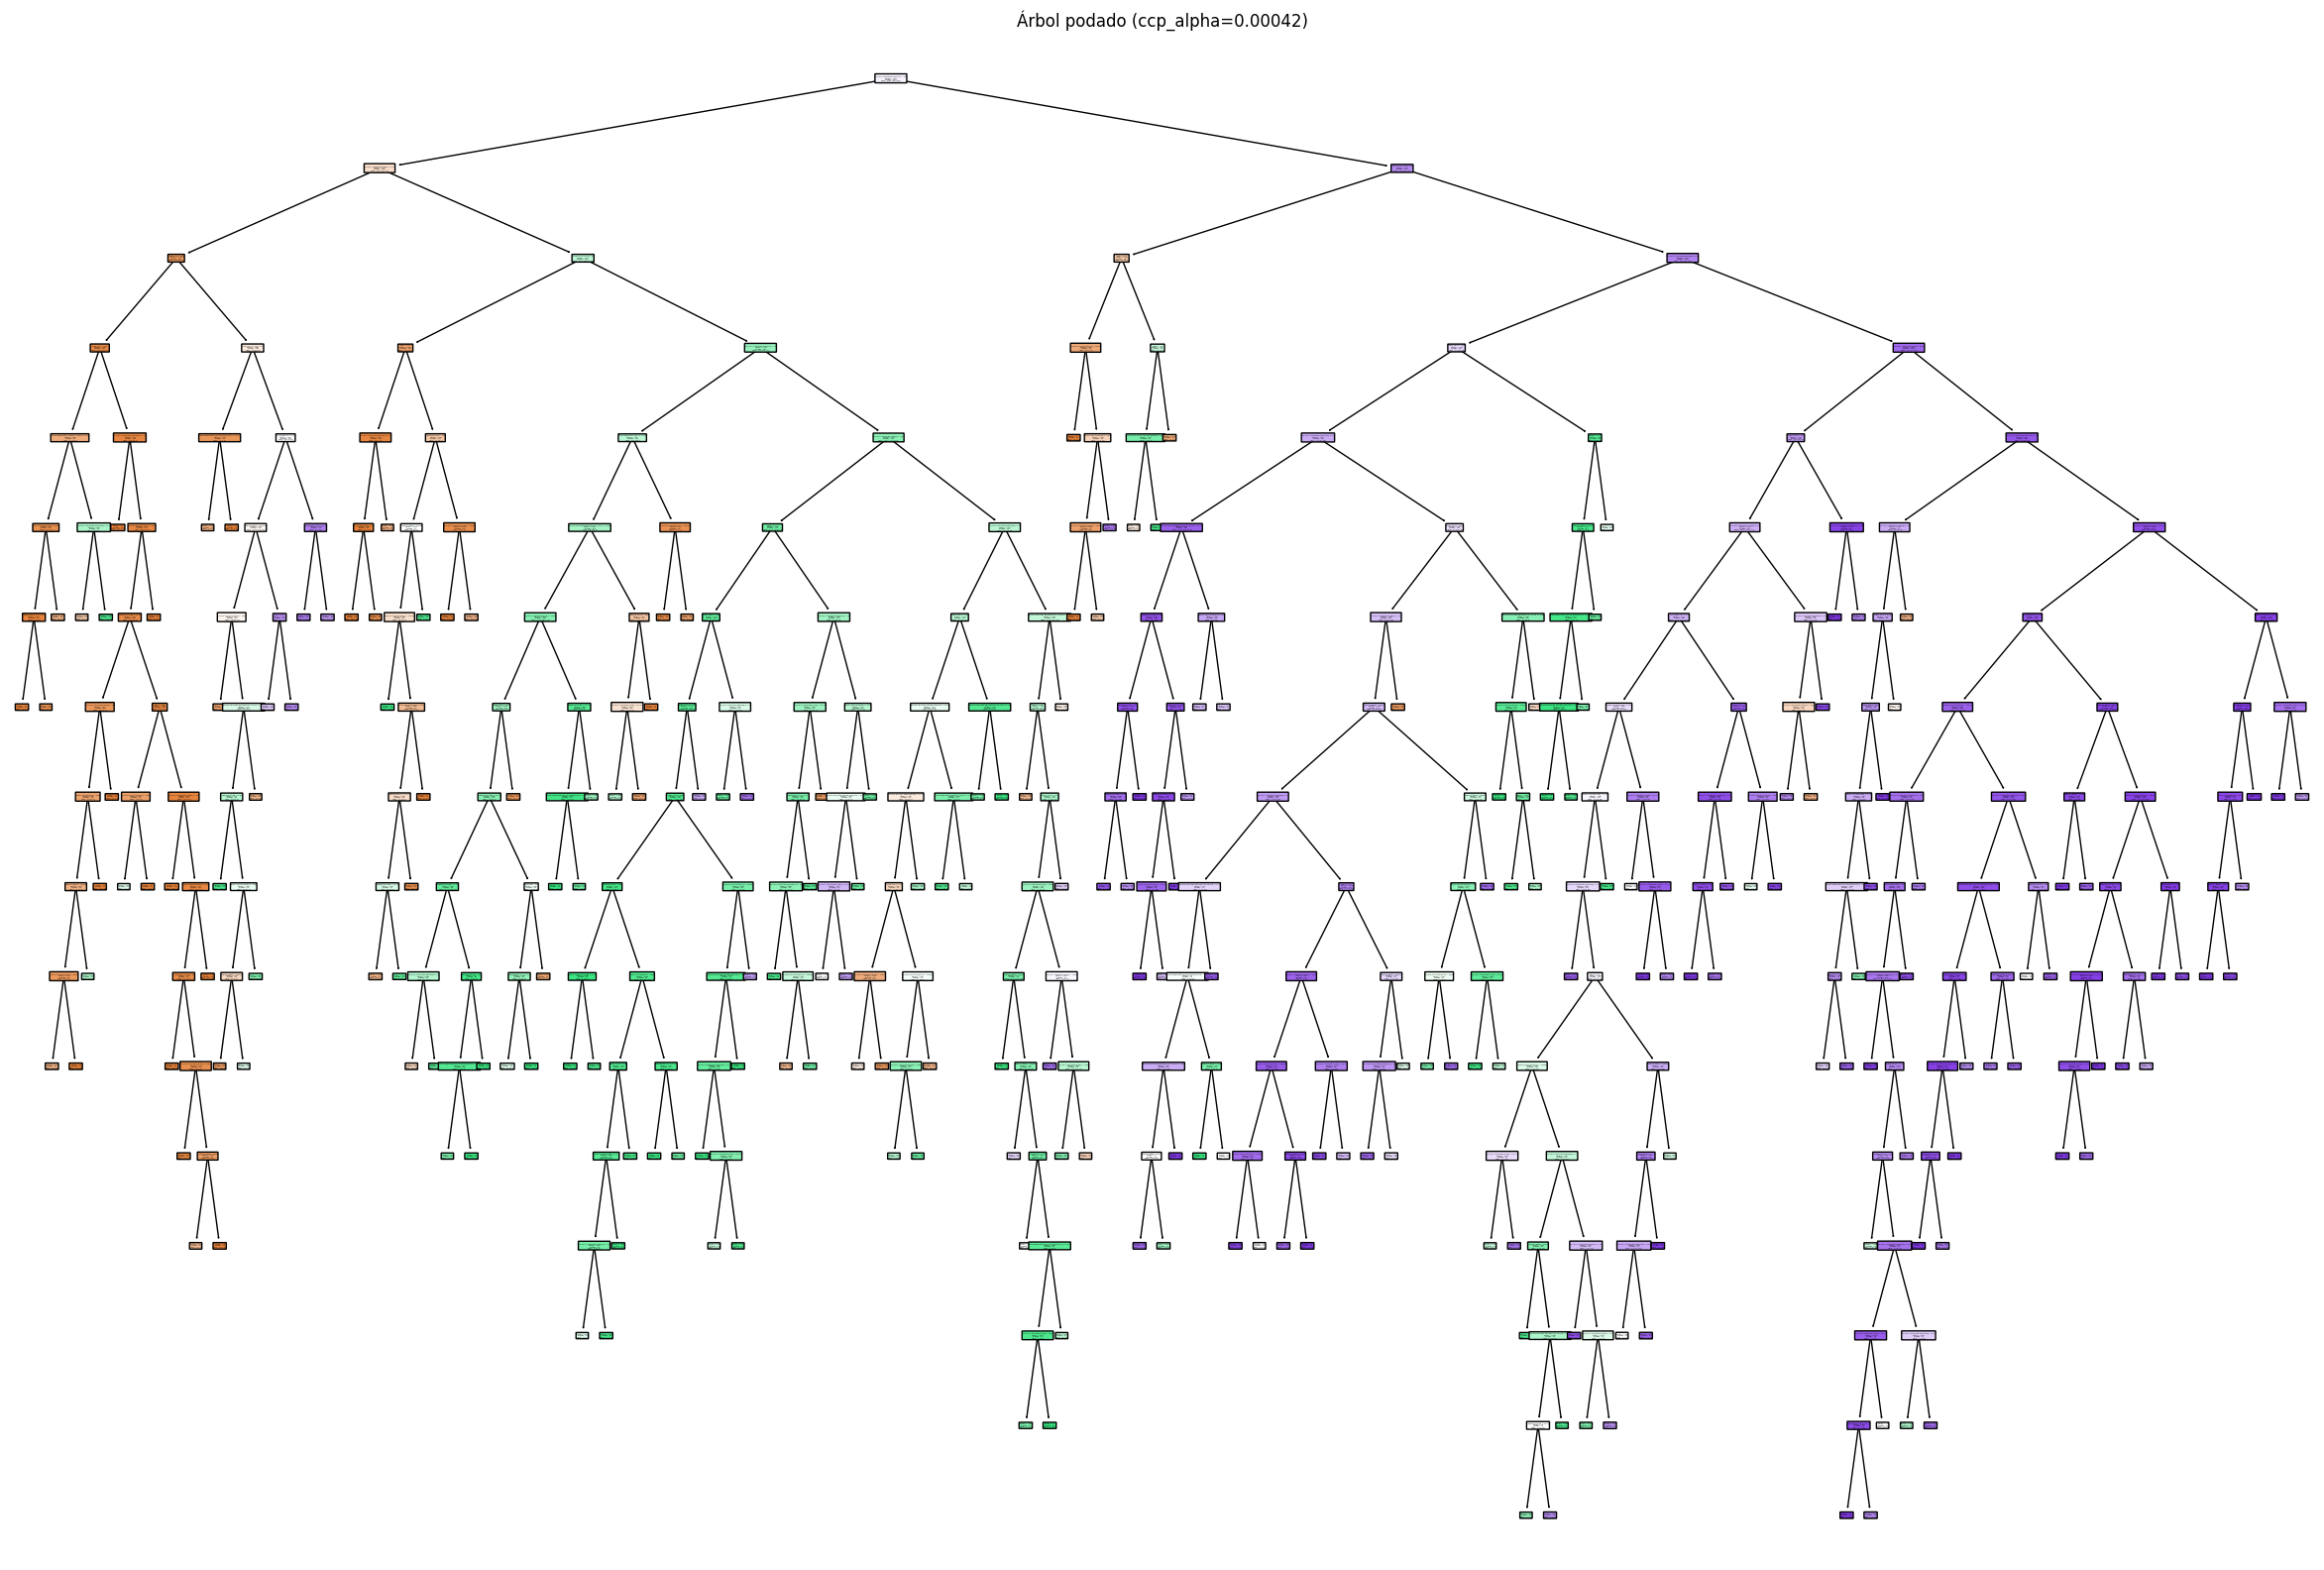

In [ ]:
plt.figure(figsize=(30,20))
plot_tree(
    final_clf,
    feature_names=X.columns,
    class_names=TARGET_NAMES,
    filled=True,
    fontsize=1,
    rounded=True
)
plt.title(f"Árbol podado (ccp_alpha={best_alpha:.5f})")
plt.savefig('arboles/arbol_podado_entropy.svg', format='svg')
plt.show()